In [126]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm

In [68]:

# import data

df = pd.read_excel("Price History_2025.xlsx")
if df.empty:
    raise ValueError("Failed to load data. Try again later.")

predict_column = 'Index Price'
predict_length = 5

df["Exchange Date"] = pd.to_datetime(df["Exchange Date"])
df.set_index("Exchange Date", inplace=True)
df.dropna(inplace=True)
df = df.sort_index(ascending=True)

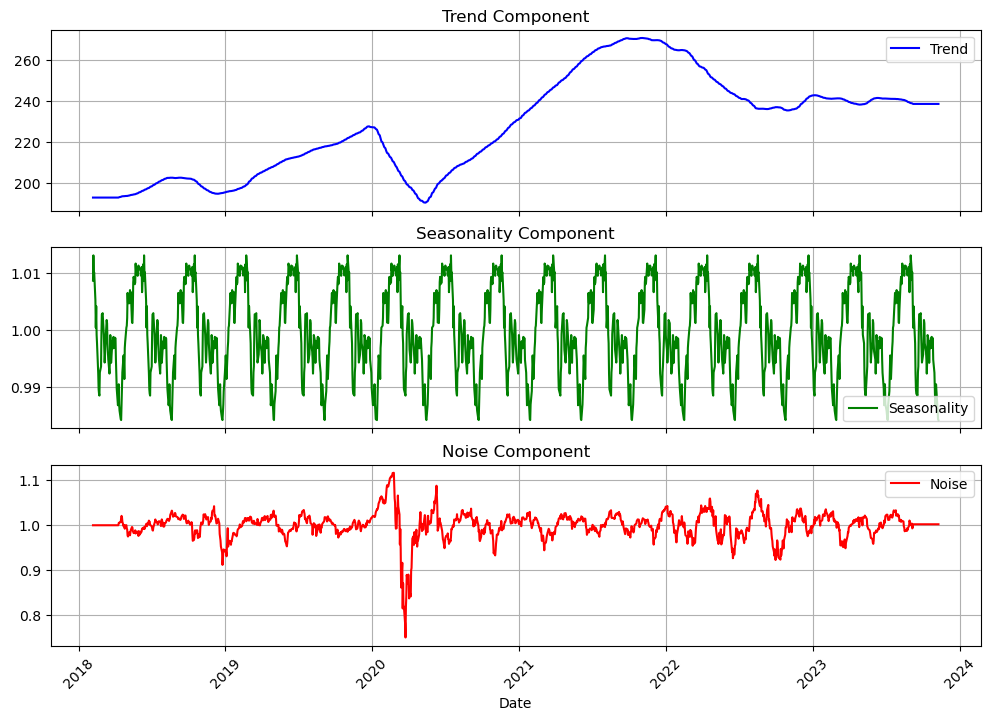

In [102]:
decomposition = seasonal_decompose(df[predict_column], model="multiplicative", period=90)

# Store components
df["Trend"] = decomposition.trend
df["Seasonality"] = decomposition.seasonal
df["Noise"] = decomposition.resid

# Fill NaN values in trend and residuals (first/last periods might be missing)
df.fillna(method="bfill", inplace=True)
df.fillna(method="ffill", inplace=True)

# Plot decomposition with dates on the x-axis
fig, axes = plt.subplots(4, 1, figsize=(16, 8), sharex=True)

axes[0].plot(df.index, df["Index Price"], label="Price", color="black")
axes[1].plot(df.index, df["Trend"], label="Trend", color="blue")
axes[2].plot(df.index, df["Seasonality"], label="Seasonality", color="green")
axes[3].plot(df.index, df["Noise"], label="Noise", color="red")

axes[0].set_title("Price")
axes[1].set_title("Trend Component")
axes[2].set_title("Seasonality Component")
axes[3].set_title("Noise Component")

for ax in axes:
    ax.legend()
    ax.grid()

plt.xlabel("Date")
plt.xticks(rotation=45)
plt.show()

In [90]:

df["RSI_7"] = ta.rsi(df[predict_column], length=7)
df["RSI_14"] = ta.rsi(df[predict_column], length=14)
df["RSI_21"] = ta.rsi(df[predict_column], length=21)
df["MACD_12_26"] = ta.macd(df[predict_column], fast=12, slow=26)["MACD_12_26_9"]
df["MACD_6_13"] = ta.macd(df[predict_column], fast=6, slow=13)["MACD_6_13_9"]
df["BBANDS_U"] = ta.bbands(df[predict_column], length=20)["BBU_20_2.0"]
df["BBANDS_L"] = ta.bbands(df[predict_column], length=20)["BBL_20_2.0"]


# Compute the target variable (price change)
for n in range(predict_length):
    df[f"Change_{n+1}"] = df[predict_column].diff(-n-1).shift(n+1)/df[predict_column].shift(n+1)

df.dropna(inplace=True)

In [92]:
df.tail()

,Index Price,Trend,Seasonality,Noise,RSI_7,RSI_14,RSI_21,MACD_12_26,MACD_6_13,BBANDS_U,BBANDS_L,Change_1,Change_2,Change_3,Change_4,Change_5
Exchange Date,,,,,,,,,,,,,,,,
2023-11-03,234.63,229.790667,1.002973,0.993272,70.018028,57.672651,52.926659,-1.120416,0.673047,236.477930,224.459070,-0.008858,-0.024004,-0.028944,-0.037543,-0.045588
2023-11-06,234.14,229.790667,1.002303,0.993272,67.117359,56.396254,52.090095,-0.713153,1.059213,236.761814,224.387186,0.002088,-0.006751,-0.021865,-0.026795,-0.035376
2023-11-07,233.51,229.790667,1.000769,0.993272,63.190620,54.719433,51.001807,-0.436202,1.162407,236.787322,224.379678,0.002691,0.004773,-0.004042,-0.019116,-0.024032
2023-11-08,232.97,229.790667,0.999402,0.993272,59.697957,53.257736,50.060510,-0.257323,1.100999,236.726656,224.395344,0.002313,0.004997,0.007075,-0.001720,-0.016759
2023-11-09,231.25,229.790667,0.999109,0.993272,49.525722,48.787377,47.150141,-0.251452,0.772750,236.758015,224.412985,0.007383,0.009678,0.012343,0.014406,0.005676


In [138]:
# Split data (last 5 points as test)
split_index = int(len(df) -5)
train, test = df.iloc[:split_index], df.iloc[split_index:]

# Extract features and targets
diff_columns = [f'Change_{n+1}' for n in range(predict_length)]
predict_columns = [predict_column]+diff_columns 
feature_cols = df.columns.difference(predict_columns)
X_train, X_test = train[feature_cols], test[feature_cols]
y_train, y_test = train[diff_columns], test[diff_columns]

selected_features = X_train.columns
X_train, X_test = X_train[selected_features], X_test[selected_features]

In [140]:
# Normalize data for ML models
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
# Evaluation
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred)
    print(f"{model_name} MAE: {mae:.4f}, RMSE: {rmse:.4f}")

In [144]:
# ARIMA Model
# Fit the best ARIMA model using auto_arima
auto_arima_model = pm.auto_arima(
    train[predict_column],
    seasonal=False,  # Set True if you expect seasonality
    stepwise=True,   # Efficient search
    suppress_warnings=True,
    error_action="ignore",
    trace=True       # Shows progress
)

# Get best parameters
best_order = auto_arima_model.order
print(f"Best ARIMA order: {best_order}")

# Fit ARIMA using best parameters
arima_preds = []
model = ARIMA(train[predict_column], order=best_order)
arima_model = model.fit()
forecast = arima_model.forecast(steps=5)
arima_preds=forecast.values

arima_preds = np.array(arima_preds)
evaluate(y_test, arima_preds, "ARIMA")
arima_preds

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6771.321, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6827.440, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6818.516, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6820.441, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6825.645, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6804.318, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6805.762, Time=0.65 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=6767.631, Time=2.13 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=6806.309, Time=1.02 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=6769.497, Time=2.54 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=6774.389, Time=2.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=6807.441, Time=0.74 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=6778.429, Time=1.54 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=6769.224, Time=3.26 sec
 ARIMA(3,1,2)(0,0,0)[0]          

C:\Users\Estera\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Estera\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Estera\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Estera\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: Found input variables with inconsistent numbers of samples: [5, 1]

In [157]:
evaluate(arima_preds[0], test[predict_column], "ARIMA")
# arima_preds[0], test[predict_column]

ARIMA MAE: 1.3684, RMSE: 2.3575


In [ ]:
# SVM Model
svm_models = [SVR(kernel="rbf") for _ in range(3)]
for i in range(3):
    svm_models[i].fit(X_train_scaled, y_train.iloc[:, i])
svm_preds = np.array([model.predict(X_test_scaled) for model in svm_models]).T

# LSTM Model
X_train_lstm = X_train_scaled.reshape(-1, 1, len(selected_features))
X_test_lstm = X_test_scaled.reshape(-1, 1, len(selected_features))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(1, len(selected_features))),
    LSTM(50),
    Dense(3)
])
lstm_model.compile(optimizer="adam", loss="rmse")
lstm_model.fit(X_train_lstm, y_train, epochs=20, batch_size=16, verbose=0)
lstm_preds = lstm_model.predict(X_test_lstm)

# CNN Model
X_train_cnn = X_train_scaled.reshape(-1, 1, len(selected_features))
X_test_cnn = X_test_scaled.reshape(-1, 1, len(selected_features))

cnn_model = Sequential([
    Conv1D(32, kernel_size=1, activation="relu", input_shape=(1, len(selected_features))),
    Flatten(),
    Dense(50, activation="relu"),
    Dense(3)
])
cnn_model.compile(optimizer="adam", loss="rmse")
cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=16, verbose=0)
cnn_preds = cnn_model.predict(X_test_cnn)


evaluate(y_test, arima_preds, "ARIMA")
evaluate(y_test, svm_preds, "SVM")
evaluate(y_test, lstm_preds, "LSTM")
evaluate(y_test, cnn_preds, "CNN")

C:\Users\Estera\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Estera\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Estera\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Estera\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressiv

ValueError: in user code:

    File "C:\Users\Estera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Estera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Estera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Estera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Estera\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "C:\Users\Estera\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Estera\anaconda3\lib\site-packages\keras\src\losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\Estera\anaconda3\lib\site-packages\keras\src\losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Estera\anaconda3\lib\site-packages\keras\src\losses.py", line 1749, in mean_absolute_error
        return backend.mean(tf.abs(y_pred - y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 3 and 5 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](sequential/dense/BiasAdd, Cast)' with input shapes: [?,3], [?,5].


In [ ]:
# Plot Results
y_labels = [str(date) for tick, date in y_test.index]
plt.figure(figsize=(12,6))
plt.plot(y_labels, y_test.iloc[:, 0], label="Actual Change", color="black", linestyle="dotted")
# plt.plot(y_labels, arima_preds[:, 0], label="ARIMA", alpha=0.7)
plt.plot(y_labels, svm_preds[:, 0]*10, label="SVM", alpha=0.7)
plt.plot(y_labels, lstm_preds[:, 0]*10, label="LSTM", alpha=0.7)
# plt.plot(y_labels, cnn_preds[:, 0]*10, label="CNN", alpha=0.7)
plt.legend()
plt.title(f"Stock Price Change Prediction for {ticker}")
plt.xlabel("Date")
plt.ylabel("Price Change")
plt.show()

In [43]:
y_test.index

MultiIndex([('AAPL', 2025-02-12),
            ('AAPL', 2025-02-13),
            ('AAPL', 2025-02-14),
            ('AAPL', 2025-02-18),
            ('AAPL', 2025-02-19),
            ('AAPL', 2025-02-20),
            ('AAPL', 2025-02-21),
            ('AAPL', 2025-02-24),
            ('AAPL', 2025-02-25),
            ('AAPL', 2025-02-26),
            ('AAPL', 2025-02-27),
            ('AAPL', 2025-02-28),
            ('AAPL', 2025-03-03),
            ('AAPL', 2025-03-04),
            ('AAPL', 2025-03-05),
            ('AAPL', 2025-03-06),
            ('AAPL', 2025-03-07),
            ('AAPL', 2025-03-10),
            ('AAPL', 2025-03-11),
            ('AAPL', 2025-03-12),
            ('AAPL', 2025-03-13),
            ('AAPL', 2025-03-14),
            ('AAPL', 2025-03-17)],
           names=['symbol', 'date'])